Imports

In [1]:
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
from pyspark.sql.functions import col, count, when, lit
import os

print(_find_spark_home())

C:\Users\f\anaconda3\envs\BigDataProject\Lib\site-packages\pyspark


Setting up PySpark configurations

In [2]:
conf = (
    SparkConf()
    .setMaster("local[*]")
    .set("spark-local-dir", "C:\\spark-temp")
    .set("spark.driver.memory", "8g")
    .set("spark.executor.memory", "6g")
    .set("spark.driver.maxResultSize", "4g")
    .set(
        "spark.pyspark.python",
        "C:\\Users\f\\anaconda3\\envs\\BigDataProject\python.exe",
    )
    .set(
        "spark.pyspark.driver.python",
        "C:\\Users\f\\anaconda3\\envs\\BigDataProject\python.exe",
    )
)


spark = SparkSession.builder.appName("CovidAgeComparison").config(conf=conf).getOrCreate()

sc = spark.sparkContext

for item in sc.getConf().getAll():
    print(item)

('spark.app.name', 'CovidAgeComparison')
('spark.pyspark.driver.python', 'C:\\Users\x0c\\anaconda3\\envs\\BigDataProject\\python.exe')
('spark.driver.port', '53688')
('spark.driver.host', '192.168.0.14')
('spark.app.id', 'local-1703092586496')
('spark.executor.id', 'driver')
('spark.executor.memory', '6g')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-o

Loading CSV file from HDFS

In [7]:
# path to CSV file in HDFS
csv_file_path = (
    "hdfs://localhost:9000/mydataset/COVID-19_Case_Surveillance_Public_Use_Data.csv"
)

# Load the CSV file into a DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

Primary exploration of the dataset

In [8]:
df.show()

+---------------------+-------------+-----------+----------+--------------------+------+-------------+-----------------------+-------+-------+--------+----------+
|cdc_case_earliest_dt |cdc_report_dt|pos_spec_dt|  onset_dt|      current_status|   sex|    age_group|race_ethnicity_combined|hosp_yn| icu_yn|death_yn|medcond_yn|
+---------------------+-------------+-----------+----------+--------------------+------+-------------+-----------------------+-------+-------+--------+----------+
|           2022/11/10|   2022/11/11|       null|2022/11/10|Laboratory-confir...|Female|20 - 29 Years|    White, Non-Hispanic|     No|Missing|      No|   Missing|
|           2022/09/01|   2022/09/01|       null|2022/09/01|Laboratory-confir...|Female|20 - 29 Years|    White, Non-Hispanic|     No|Missing|      No|   Missing|
|           2020/12/28|   2021/01/07|       null|2020/12/28|Laboratory-confir...|Female|20 - 29 Years|    White, Non-Hispanic|     No|Missing|      No|   Missing|
|           2021/12/18

In [4]:
# Counting the amount of instances we have
df.count()

101766479

In [5]:
# Exploring the types of columns we have in the dataset
df.printSchema()

root
 |-- cdc_case_earliest_dt : string (nullable = true)
 |-- cdc_report_dt: string (nullable = true)
 |-- pos_spec_dt: string (nullable = true)
 |-- onset_dt: string (nullable = true)
 |-- current_status: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- race_ethnicity_combined: string (nullable = true)
 |-- hosp_yn: string (nullable = true)
 |-- icu_yn: string (nullable = true)
 |-- death_yn: string (nullable = true)
 |-- medcond_yn: string (nullable = true)



In [6]:
# Exploring current_status column
df.groupBy(col("current_status")).agg(count("current_status").alias("count")).show()

+--------------------+--------+
|      current_status|   count|
+--------------------+--------+
|       Probable Case|17862700|
|Laboratory-confir...|83903779|
+--------------------+--------+



Initial filtering

In [9]:
# Filtering the instances that are confirmed and without a previous health condition
df_filtered = df.filter(col("current_status") != "Probable Case")
df_filtered = df_filtered.filter(col("medcond_yn") == "No")
df_filtered.groupBy(col("current_status")).agg(
    count("current_status").alias("count")
).show()
df_filtered.groupBy(col("medcond_yn")).agg(count("medcond_yn").alias("count")).show()

+--------------------+-------+
|      current_status|  count|
+--------------------+-------+
|Laboratory-confir...|4623658|
+--------------------+-------+

+----------+-------+
|medcond_yn|  count|
+----------+-------+
|        No|4623658|
+----------+-------+



In [10]:
# Save the filtered dataset
df_filtered.write.format("csv").mode("overwrite").save("hdfs://localhost:9000/mydataset/filtered/")

In [11]:
# The new count after filtering
df_filtered.count()

4623658

Cleaning the dataset

In [12]:
# Dropping unwanted columns
reduced_df = df_filtered.drop(
    "cdc_case_earliest_dt ",
    "cdc_report_dt",
    "pos_spec_dt",
    "onset_dt",
    "current_status",
    "sex",
    "race_ethnicity_combined",
    "icu_yn",
    "death_yn",
    "medcond_yn",
)

In [13]:
reduced_df.show()

+-------------+-------+
|    age_group|hosp_yn|
+-------------+-------+
|20 - 29 Years|Unknown|
|20 - 29 Years|Unknown|
|20 - 29 Years|     No|
|20 - 29 Years|Unknown|
|20 - 29 Years|     No|
|20 - 29 Years|Unknown|
|20 - 29 Years|Unknown|
|20 - 29 Years|     No|
|20 - 29 Years|     No|
|20 - 29 Years|     No|
|20 - 29 Years|Unknown|
|20 - 29 Years|     No|
|20 - 29 Years|     No|
|20 - 29 Years|Unknown|
|20 - 29 Years|     No|
|20 - 29 Years|     No|
|20 - 29 Years|Unknown|
|20 - 29 Years|Unknown|
|20 - 29 Years|     No|
|20 - 29 Years|     No|
+-------------+-------+
only showing top 20 rows



In [14]:
# Checking what classes does the age_group and the hosp_yn columns has
for col_name in reduced_df.columns:
    print(f"Unique values and counts in column: {col_name}")
    reduced_df.groupBy(col(col_name)).agg(count(col_name).alias("count")).show()

Unique values and counts in column: age_group
+-------------+------+
|    age_group| count|
+-------------+------+
|20 - 29 Years|885723|
|40 - 49 Years|622224|
|50 - 59 Years|512153|
|70 - 79 Years|193675|
|  0 - 9 Years|479513|
|30 - 39 Years|777522|
|      Missing|   956|
|10 - 19 Years|695394|
|    80+ Years| 96854|
|60 - 69 Years|359635|
|           NA|     9|
+-------------+------+

Unique values and counts in column: hosp_yn
+-------+-------+
|hosp_yn|  count|
+-------+-------+
|Unknown|1853625|
|     No|2270117|
|    Yes| 114809|
|Missing| 385107|
+-------+-------+



In [15]:
# Cleaning missing and not available data instances
df_filtered2 = reduced_df.dropna()
df_filtered2 = df_filtered2.filter(col("age_group") != "Missing")
df_filtered2 = df_filtered2.filter(col("age_group") != "NA")
df_filtered2 = df_filtered2.filter(col("hosp_yn") != "Missing")
df_filtered2 = df_filtered2.filter(col("hosp_yn") != "Unknown")

In [17]:
# Checking out what the columns look like after cleaning
for col_name in df_filtered2.columns:
    print(f"Unique values and counts in column: {col_name}")
    df_filtered2.groupBy(col(col_name)).agg(count(col_name).alias("count")).show()

Unique values and counts in column: age_group
+-------------+------+
|    age_group| count|
+-------------+------+
|20 - 29 Years|477964|
|40 - 49 Years|316328|
|50 - 59 Years|252701|
|70 - 79 Years| 84511|
|  0 - 9 Years|254104|
|30 - 39 Years|400488|
|10 - 19 Years|389182|
|    80+ Years| 40645|
|60 - 69 Years|168765|
+-------------+------+

Unique values and counts in column: hosp_yn
+-------+-------+
|hosp_yn|  count|
+-------+-------+
|     No|2269888|
|    Yes| 114800|
+-------+-------+



Dividing instances based on age

In [18]:
# Devding age instances into two distinct categories above and under 40
categorized_df = df_filtered2.withColumn(
    "age_category",
    when(
        col("age_group").isin(
            "0 - 9 Years", "10 - 19 Years", "20 - 29 Years", "30 - 39 Years"
        ),
        "under 40",
    ).otherwise("above 40"),
)

# Dropping the old age column
final_df = categorized_df.drop("age_group")

# Showing the results after the division
for col_name in final_df.columns:
    print(f"Unique values and counts in column: {col_name}")
    final_df.groupBy(col(col_name)).agg(count(col_name).alias("count")).show()

Unique values and counts in column: hosp_yn
+-------+-------+
|hosp_yn|  count|
+-------+-------+
|     No|2269888|
|    Yes| 114800|
+-------+-------+

Unique values and counts in column: age_category
+------------+-------+
|age_category|  count|
+------------+-------+
|    under 40|1521738|
|    above 40| 862950|
+------------+-------+



In [22]:
final_df.write.format("csv").mode("overwrite").save("hdfs://localhost:9000/mydataset/finalDataset/")

Getting the results

In [23]:
# Group by age_category and calculate counts
age_hosp_counts = final_df.groupBy("age_category").agg(
    count(lit(1)).alias("total"),
    count(when(col("hosp_yn") == "Yes", True)).alias("hospitalized"),
)

In [24]:
# With caring about it being a confirmed case and no health conditions with it
# Calculate the percentage of hospitalizations
age_hosp_percent = age_hosp_counts.withColumn(
    "hospitalization_percent", (col("hospitalized") / col("total")) * 100
)

age_hosp_percent.show()

+------------+-------+------------+-----------------------+
|age_category|  total|hospitalized|hospitalization_percent|
+------------+-------+------------+-----------------------+
|    under 40|1521738|       31901|      2.096352985862218|
|    above 40| 862950|       82899|      9.606466191552233|
+------------+-------+------------+-----------------------+



Visualizing the result

In [25]:
# Collecting the percentages to use later
age_hosp_data = age_hosp_percent.collect()

In [26]:
# Creating the x-y that will be used later in the plot
categories = [row["age_category"] for row in age_hosp_data]
percentages = [row["hospitalization_percent"] for row in age_hosp_data]

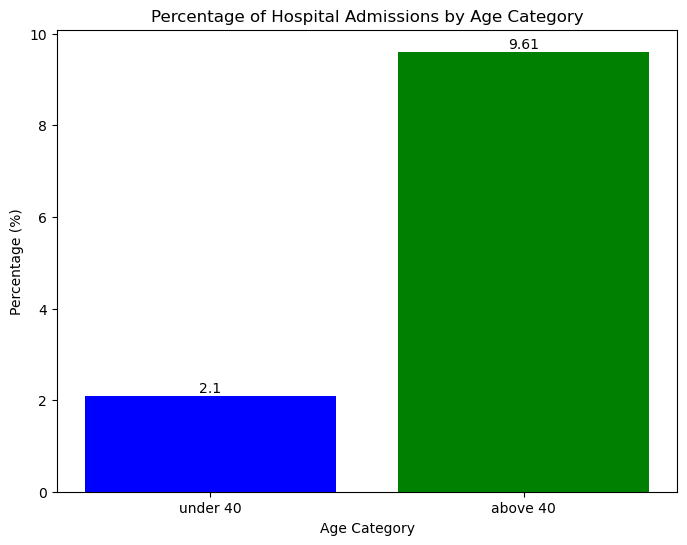

In [27]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=["blue", "green"])

# Adding titles and labels
plt.title("Percentage of Hospital Admissions by Age Category")
plt.xlabel("Age Category")
plt.ylabel("Percentage (%)")
plt.xticks(categories)

# Adding percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

# Show the plot
plt.show()